# Topological Machine Learning Project - INF367AII

By: *Willem Schooltink*

This notebook is the application part of the TML project of INF367AII. In this notebook topological techniques will be used to quantify how smoothly wealth (measured by GDP per capita) is distributed over the world. Note that 'smoothly' here does not mean checking if all countries have equal GDP, but how smooth the transition is from wealthy parts of the world to unwealthy parts of the world.

In [1]:
import matplotlib.pyplot as plt
import json
import csv
import numpy as np
import graph as g
import networkx as nx
import math
import homology as hm

## Loading and pre-processing the data

For this application we combine 2 datasets (both sourced from Kaggle):
- [GDP per capita all counties](https://www.kaggle.com/datasets/nitishabharathi/gdp-per-capita-all-countries)
- [World Polygon Geometry](https://www.kaggle.com/datasets/syedjaferk/world-polygon-geometry)

### The goal
The goal of this pre-processing step is to convert the datafiles to a Graph where countries are nodes, and neighbouring countries are connected with an edge. Furthermore we want each node to hold information on the GDP per capita of that country.


### The steps:
#### 1. Process the geometry
The geometry dataset contains a set of relatively low-resolution polygons for all countries, together with their country-code, and Name. For most countries only a single polygon is needed to describe the shape, but for some multiple are needed (countries with detached islands, or exclaves). First we flatten all polygons into 1 list of vertices, we then create a node in the graph for the country and set it's 2d coordinates to the avarage of its vertices. These coordinates are not entirely necessary, but are nice to include for visualization.

Then we need to add edges between connected countries: All polygons are simply a set of vertices that define the border, so in order to check whether countries are connected we simply need to check whether the intersection of the set of vertices of 2 countries is not empty (*Note that this only works on datasets where countries borders are defined by exactly the same vertices in both polygons*). If we find such a non-empty intersection we draw an edge between the 2 nodes.

#### 2. Combine GDP dataset
We also want each node to contain information about the country, in our case: GDP per capita. To do this we look up the country code of the polygon in the GDP dataset and check if it has a value. Here we run into some issues: the GDP dataset is not entirely complete and will sometimes not have information on a specific country, if this is the case we fall back and set the GDP for that country to 0. All other countries a value of the percentage value of their GDP compared to the highest GDP (so between 1 and 0).

When those steps are done we are left with a graph of the countries of the world, which can nicely be visualized.

In [2]:
def load_data():
    f = open("countries.geo.json")
    return json.load(f)

def load_csv_data(file_name):
    with open(file_name, newline='') as f:
        reader = csv.reader(f)
        data = list(reader)
        return data

gdp = load_csv_data('GDP.csv')

def attributes_for_country(country_code):
    max_gdp = max([float(x[-2]) for x in gdp[1:] if x[-2] != ''])
    data = [x for x in gdp if x[1] == country_code]
    if len(data) == 0 or data[0][-2] == '':
        print(f'    Could not find GDP data for {country_code} using default = 0')
        val = 0.
    else:
        val = float(data[0][-2])

    color = val / max_gdp
    return {'color': color}


def process_geometry(data):
    # Itterate over all countries
    graph = g.Graph(0, dimensions=2)
    country_dict = {}

    print("Getting polygon points")
    for f in data['features']:
        geometry = f['geometry']
        points = geometry['coordinates']
        if geometry['type'] == 'MultiPolygon':
            array = points[0]
            for i in range(1, len(points)):
                array[0] += points[i][0]
            points = np.array(array)
        elif f['properties']['name'] == "South Africa":  # South Africa has a hole in its country, making it a bit odd to handle
            array = points[0]
            for i in range(1, len(points)):
                array += points[i]
            points = np.array([array])
        else:
            points = np.array(points)
        points = np.squeeze(points)

        country_dict[f['id']] = graph.add_node(np.average(points, axis=0), attrs=attributes_for_country(f['id'])), points

    print("Connecting nodes")
    connect_countries(country_dict)
    print("Done")
    return graph


def connect_countries(country_dict):
    keys = list(country_dict.keys())
    for i in range(len(keys)):
        for j in range(i + 1, len(keys)):
            intersecting_points = [x for x in set(tuple(x) for x in country_dict[keys[i]][1]) & set(tuple(x) for x in country_dict[keys[j]][1])]
            if len(intersecting_points) > 1:
                country_dict[keys[i]][0].connect(country_dict[keys[j]][0])


data = load_data()
graph = process_geometry(data)

Getting polygon points
    Could not find GDP data for ATA using default = 0
    Could not find GDP data for ATF using default = 0
    Could not find GDP data for BMU using default = 0
    Could not find GDP data for CUB using default = 0
    Could not find GDP data for -99 using default = 0
    Could not find GDP data for DJI using default = 0
    Could not find GDP data for ERI using default = 0
    Could not find GDP data for FLK using default = 0
    Could not find GDP data for GRL using default = 0
    Could not find GDP data for GUF using default = 0
    Could not find GDP data for IRN using default = 0
    Could not find GDP data for CS-KM using default = 0
    Could not find GDP data for NCL using default = 0
    Could not find GDP data for PRK using default = 0
    Could not find GDP data for ESH using default = 0
    Could not find GDP data for SSD using default = 0
    Could not find GDP data for -99 using default = 0
    Could not find GDP data for SOM using default = 0
   

## Visualizing the data:

We have a graph of connected nodes with data on GDP as well, so it's time to create a nice visual. To do this we convert the graph to a ```networkx``` graph, which can be displayed using ```matplotlib```. The functions below convert the original graph to the ```networkx``` graph, and create a color map for the nodes. Then the graph is displayed and printed below.

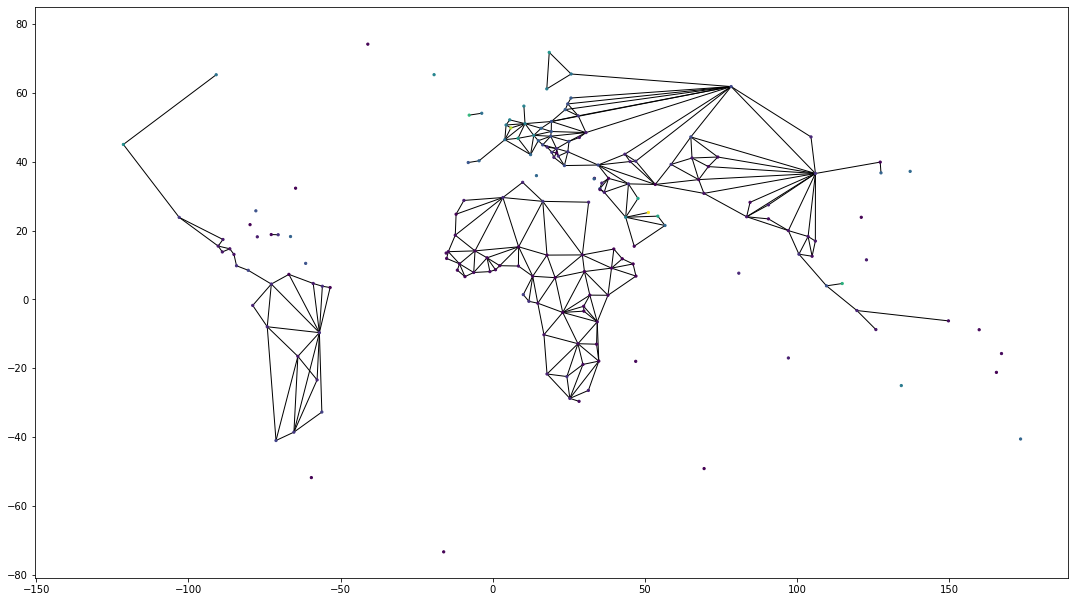

In [3]:
def display_graph(g):
    nx_graph, color_map = to_nx_graph(g)

    fig, ax = plt.subplots()
    fig.set_size_inches(18.5, 10.5)
    nx.draw(nx_graph, nx.get_node_attributes(nx_graph,'pos'), node_size=5, node_color=color_map)
    limits=plt.axis('on')
    ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
    plt.show()
    plt.close(fig)

def to_nx_graph(graph):
    export = nx.Graph()
    added_nodes = []
    color_map = []
    for node in graph.nodes.flatten():
        export.add_node(node, pos=node.coordinates)
        added_nodes.append(node)
        color_map.append(node.attrs['color'])
    for edge in graph.get_edges():
        export.add_edge(added_nodes[edge[0]], added_nodes[edge[1]])
    return export, color_map


display_graph(graph)

Now we have the graph we can see how smoothly wealth is divided among countries: mainly we see a relatively smooth gradient from europe to Russia/Asia, and a rather sudden spike in the arabian peninsula. While we can get a good intuition from this image, in order to process this data it would be nice to put this into numbers. That is where the topological techniques come into play:

We will create a filtered simplicial complex, using the graph we have created: We will create a complex where we keep the same connections as in the graph, but we set the distance between 2 connected nodes to be the difference in GDP. This means if 2 countries have a similar GDP the distance between them is small, and if there is a great difference the distance is larger.

Aditionally an additional Filtered simplicial complex will be created, where the 0-simplexes are added based on their GDP. The distance between all edges will then effectively be 0, so as soon as a 0-simplex is added it will create 1 simplexes with all it's neighbouring simplexes that already exist.

## The steps:

### 1. Create the distance matrix.
This step is fairly straight forward, given the information above. For all connected countries the distance is set to be the difference in GDP, and between unconnected countries the distance is set to infinity.

In [4]:
def create_distance_matrix(graph):
    matrix = np.zeros((len(graph.nodes), len(graph.nodes)))
    for i in range(len(graph.nodes)):
        for j in range(i + 1, len(graph.nodes)):
            node_i = graph.nodes[i]
            node_j = graph.nodes[j]

            if node_i in node_j.neighbours:
                # Set distance to connected nodes to be the differences in GDP
                distance = math.fabs(node_i.attrs['color'] - node_j.attrs['color'])
            else:
                # If nodes are not connected distance is set to infinity
                distance = np.inf

            matrix[i,j] = matrix [j,i] = distance
    return matrix

distance_matrix = create_distance_matrix(graph)

### 2. Create the distance filtered simplicial complex
To create the distance-based filtered simplicial complex using the difference in GDP as distance we use a slightly adapted Rips algorithm, we only make sure to ignore all distances that are infinity (unconnected countries). The function outputs a filtered simplicial complex, as well a list of birth-values for each simplex.

In [5]:
def create_distance_filtered_complex(distance_matrix):
    print("Generating Filtered Simplicial Complex")
    distance_matrix = distance_matrix.copy()

    for j in range(distance_matrix.shape[0]):
        distance_matrix[j, j] = np.inf  # Set all nodes to have infinite distance to themselves, so they don't get added again.

    filtered_simplexes = np.array([np.zeros(len(distance_matrix[0])) for _ in range(distance_matrix.shape[0])])
    labels = [0. for _ in range(distance_matrix.shape[0])]

    min_index = np.unravel_index(np.argmin(distance_matrix, axis=None), distance_matrix.shape)
    count = 1
    while distance_matrix[min_index] != np.inf:
        if count % 50 == 0:
            print(f"    Working...")
        count += 1

        new_complexes = [list(min_index)]
        while len(new_complexes) > 0:
            next_complexes = []
            for complex in new_complexes:
                filtered_simplexes = hm.add_complex(complex, filtered_simplexes)
                labels.append(distance_matrix[min_index] / 2)
                next_complexes += hm.new_complexes_created(complex, filtered_simplexes, max_dimensions=2)
            new_complexes = next_complexes

        distance_matrix[min_index] = np.inf
        distance_matrix[(min_index[1],min_index[0])] = np.inf
        min_index = np.unravel_index(np.argmin(distance_matrix, axis=None), distance_matrix.shape)

    print("Finished generating Filtered Simplicial Complex")
    return filtered_simplexes, labels

dif_filtered_complex, dif_labels = create_distance_filtered_complex(distance_matrix)

Generating Filtered Simplicial Complex
    Working...
    Working...
    Working...
    Working...
    Working...
    Working...
Finished generating Filtered Simplicial Complex


### 2. Create the staggered filtered simplicial complex
To create the staggered filtered simplicial complex using the GDP as filtration value for the 0-simplexes. Whenever a 0-simplex is added it is immediately connected to its neighbouring simplexes (that already exist), and again all 2-simplexes that are completed by the 1-simplexes. So the birth of any simplex is the maximum filtration value of its component 0-simplexes.

In [6]:
def create_gdp_filtered_complex(graph):
    print("Generating Filtered Simplicial Complex")
    nodes = [[node.attrs['color'], node] for node in graph.nodes]
    nodes.sort(key=lambda x: x[0])
    filtered_simplexes = np.ndarray((0,0))
    labels = []

    added_simplexes = []
    for idx, n in enumerate(nodes):
        new_complexes = [[]]

        if idx % 50 == 0:
            print(f"    Working...")

        while len(new_complexes) > 0:
            next_complexes = []
            for complex in new_complexes:
                filtered_simplexes = hm.add_complex(complex, filtered_simplexes)

                if len(complex) == 0:
                    added_simplexes.append((idx, len(filtered_simplexes) - 1))  # for all 0-simplexes keep a list of their index in the filtered simplicial complex

                    for other, other_index in added_simplexes:  # create 1 simplexes to all neighbouring nodes
                        if nodes[other][1] in n[1].neighbours:
                            next_complexes.append([other_index, len(filtered_simplexes) - 1])
                else:
                    next_complexes += hm.new_complexes_created(complex, filtered_simplexes, max_dimensions=2)

                labels.append(n[0])
            new_complexes = next_complexes

    print("Finished generating Filtered Simplicial Complex")
    return filtered_simplexes, labels, added_simplexes


gdp_filtered_complex, gdp_labels, gdp_index_tuples = create_gdp_filtered_complex(graph)

Generating Filtered Simplicial Complex
    Working...
    Working...
    Working...
    Working...
Finished generating Filtered Simplicial Complex


## Visualizing the persistence diagrams
Now we can plot the diagrams by first transforming the diagram to a list of birth-death tuples of simplexes, and then graphing it using ```matplotlib```. The first plot is a plot of the diagram created by the difference-based persistence diagram, the second plot by the persistence diagram where 0-simplexes' filtration value was set to their GDP.

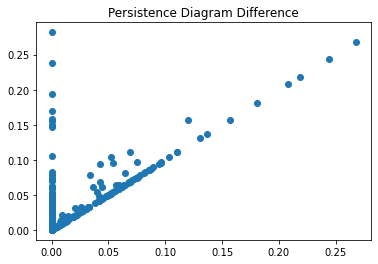

In [7]:
dif_tuples = hm.filtered_complexes_to_tuples(dif_filtered_complex, dif_labels)
plt.scatter(dif_tuples[:, 0], dif_tuples[:, 1])
plt.title('Persistence Diagram Difference')
plt.show()
plt.close()

## What does it mean?
So now we have numerical data on the division of wealth among the world, but what does it mean?
- All nodes with birth value 0 are either 0 simplexes, or edges with distance 0, so these are mostly meaningless.
- We can see how smooth the division is by looking at the spread of birth values: if all countries had the same GDP all simplexes would have a birth value of 0, higher birth values mean a larger difference in GDP between neighbouring countries.

So knowing this, what does the graph tell us? Well seeing the spread of birth values, we see that most of the world has only a slight difference in GDP between neighbouring countries. However, there do exist fewer simplexes with a relatively high birth value as well, meaning that there are places where 2 neighbouring countries have a significant difference in wealth.

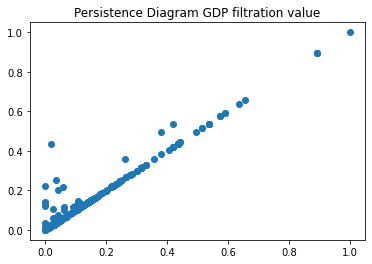

In [8]:
gdp_tuples = hm.filtered_complexes_to_tuples(gdp_filtered_complex, gdp_labels)
plt.scatter(gdp_tuples[:, 0], gdp_tuples[:, 1])
plt.title('Persistence Diagram GDP filtration value')
plt.show()
plt.close()

## What does it mean?
In the diagram where GDP was the filtration value for 0-simplexes is set to their GDP, we get a lot of information from nodes that have high persistence, these simplexes exist for a while, meaning that there is a relatively big difference between the simplex (and its component 0-simplexes) and the final 'destroyer' 0-simplex. This therefore indicates a country that is significantly wealthier than its neighbours.

In the code block below we will extract all 0-simplexes that are creators of 2-simplexes and thus is the 'most different' to their neighbours.

In [9]:
important_dif_indices = hm.get_creator_simplex_indices(dif_filtered_complex, dimension_filter=[2])

important_gdp_indices = hm.get_creator_simplex_indices(gdp_filtered_complex, dimension_filter=[2])

print("======2-simplex creator Countries (difference complex)=======")
for i in important_dif_indices:
    print(f"   {data['features'][i]['properties']['name']}")
print('')


def get_sorted_countries(data):
    sorted_countries = []
    for country in data['features']:
        gdp_country = [x for x in gdp if x[1] == country['id']]
        if len(gdp_country) == 0 or gdp_country[0][-2] == '':
            val = 0.
        else:
            val = float(gdp_country[0][-2])
        sorted_countries.append((country['properties']['name'], val))
        sorted_countries.sort(key=lambda d: d[1])
    return sorted_countries

print("======2-simplex creator Countries (difference complex)=======")
sorted_countries = get_sorted_countries(data)
for i in important_gdp_indices:
    country_idx = [x[0] for x in gdp_index_tuples if x[1] == i]
    print(f"   {sorted_countries[country_idx[0]][0]}")



======2-simplex creator Countries (difference complex)=======
   Azerbaijan
   Bolivia
   Brazil
   Chile
   China
   Ivory Coast
   Cameroon
   Democratic Republic of the Congo
   Republic of the Congo
   Czech Republic
   Germany
   Ecuador
   Ethiopia
   France
   Gabon
   Ghana
   Equatorial Guinea
   Greece
   French Guiana
   Guyana
   Honduras
   Croatia
   Hungary
   India
   Iran
   Italy
   Kazakhstan
   Kyrgyzstan
   Kuwait
   Laos
   Liberia
   Lithuania
   Luxembourg
   Latvia
   Mexico
   Macedonia
   Mali
   Myanmar
   Montenegro
   Mauritania
   Namibia
   Niger
   Nigeria
   Netherlands
   Norway
   Nepal
   Oman
   Pakistan
   Peru
   Poland
   Paraguay
   Romania
   Russia
   Rwanda
   Western Sahara
   Saudi Arabia
   Sudan
   South Sudan
   Senegal
   Somaliland
   Somalia
   Republic of Serbia
   Slovakia
   Slovenia
   Syria
   Chad
   Togo
   Thailand
   Tajikistan
   Turkmenistan
   Tunisia
   Turkey
   United Republic of Tanzania
   Uganda
   Ukraine
   Urugua

So now we have a list of countries that are relatively wealthier than its neighbouring countries, by using 2 different ways of created a filtered simplicial complex.